In [20]:
import numpy as np
from scipy.integrate import odeint
from scipy import optimize
import matplotlib.pyplot as plt

1. Определение входного воздействия u(t) и его производной u'(t)

Для единичного шага: u(t)=0 при t<0, u(t)=1 при t>=0

In [21]:
def u_func(t):
    return 1.0 if t >= 0 else 0.0

# Производная единичного шага равна 0 для t≠0 (игнорируем дельта-функцию в t=0)
def du_dt_func(t):
    return 0.0

2. Запись ДУ второго порядка в виде системы первого порядка (форма Коши)

Введём переменные:
```
x1(t) = y(t)

x2(t) = y'(t)
```

Тогда получаем систему:
```
dx1/dt = x2

dx2/dt = -a*x2 - b*x1 + c*u'(t) + d*u(t)
```

In [22]:
# Здесь параметры a, b, c, d задаются как коэффициенты, сохраняющих
# общую структуру уравнения.
def system_odes(x, t, params):
    """
    Функция для вычисления производной системы ОДУ.
    """
    a, b, c, d = params
    x1, x2 = x
    u = u_func(t)
    du = du_dt_func(t)
    dx1_dt = x2
    dx2_dt = -a * x2 - b * x1 + c * du + d * u
    return [dx1_dt, dx2_dt]

3. Функция для моделирования системы с заданными параметрами

In [23]:
def simulate_system(params, x0, t):
    """
    Функция для моделирования системы с заданными параметрами.
    """
    sol = odeint(system_odes, x0, t, args=(params,))
    return sol


4. Оценка параметров ДУ методом наименьших квадратов

Здесь мы определяем класс для оценки параметров модели по экспериментальным данным.
В данном примере данные синтезируются с использованием "истинных" параметров,
затем к ним добавляется небольшой шум.

In [24]:
class ParameterEstimator:
    def __init__(self, t_data, y_data, system_func, x0):
        """
        t_data - массив временных отсчетов,
        y_data - экспериментальные данные (выход системы, y(t)),
        system_func - функция, описывающая систему ОДУ,
        x0 - начальные условия системы (например, [0, 0])
        """
        self.t_data = t_data
        self.y_data = y_data
        self.system_func = system_func
        self.x0 = x0

    def simulate(self, params):
        """
        Моделирование системы с параметрами params, возвращает y(t)=x1(t)
        """
        sol = odeint(self.system_func, self.x0, self.t_data, args=(params,))
        return sol[:, 0]

    def residuals(self, p):
        """
        Вычисление разности между моделью и экспериментальными данными
        """
        y_sim = self.simulate(p)
        return (y_sim - self.y_data).flatten()

    def estimate(self, initial_guess):
        """
        Оценка параметров с помощью оптимизации наименьших квадратов.
        Возвращает оцененные параметры и дополнительную информацию.
        """
        p_est, cov, infodict, mesg, ier = optimize.leastsq(self.residuals, initial_guess, full_output=True)
        return p_est, cov, mesg, ier


 5. Пример использования

 Рассмотрим, уравнение:
   y''(t) + 3*y'(t) + 4*y(t) = 4*u'(t) + 2*u(t)

 В нашей записи система принимает параметры:
   a = 3, b = 4, c = 4, d = 2

Оцененные параметры:
a = 3.0000, b = 4.0000, c = 4.0000, d = 2.0000


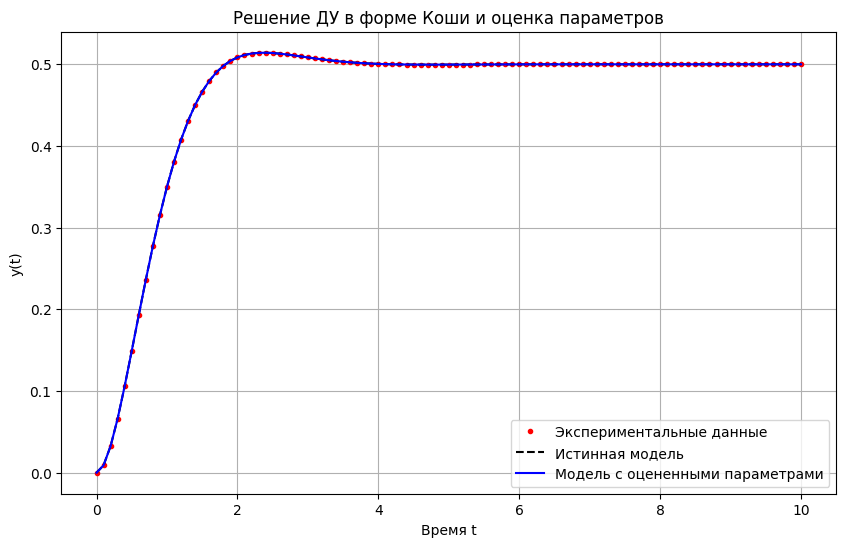

In [25]:
x0 = [0, 0]  # Начальные условия: y(0)=0, y'(0)=0
t = np.linspace(0, 10, 101)

true_params = [3, 4, 4, 2]
sol_true = simulate_system(true_params, x0, t)
y_true = sol_true[:, 0]

# Имитация эксперимента
np.random.seed(0)  # для воспроизводимости
noise_level = 0
y_noisy = y_true + noise_level * np.random.randn(len(y_true))

# Зададим начальное приближение для параметров
initial_guess = [1, 1, true_params[2], true_params[3]]

# Выполняем оценку параметров
estimator = ParameterEstimator(t, y_noisy, system_odes, x0)
estimated_params, cov, mesg, ier = estimator.estimate(initial_guess)

print("Оцененные параметры:")
print("a = {:.4f}, b = {:.4f}, c = {:.4f}, d = {:.4f}".format(
    estimated_params[0],
    estimated_params[1],
    estimated_params[2],
    estimated_params[3]
))

# Моделирование системы с оцененными параметрами:
sol_est = simulate_system(estimated_params, x0, t)
y_est = sol_est[:, 0]


# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(t, y_noisy, 'r.', label="Экспериментальные данные")
plt.plot(t, y_true, 'k--', label="Истинная модель")
plt.plot(t, y_est, 'b-', label="Модель с оцененными параметрами")
plt.xlabel("Время t")
plt.ylabel("y(t)")
plt.title("Решение ДУ в форме Коши и оценка параметров")
plt.legend()
plt.grid(True)
plt.show()
